In [1]:
import os
os.system('clear')

import numpy as np
import pandas as pd
import datetime

from termcolor import colored
from SecretColors.palette import Palette
material = Palette("material", color_mode = 'hexa')

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
mpl.rcParams['font.family'] = 'SF Compact Text'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])

# os.chdir("./nordpool")

In [ ]:
flist = [f for f in sorted(os.listdir("./raw")) if not f.startswith('.') or f.startswith('~')]

print(flist)

for filename in flist:
    print(filename)
    y = int(filename[:4])
    print(y)
    df = pd.read_excel(f"./raw/{filename}", header = None, skip_blank_lines=True, decimal=',', thousands='.')
    df = df.replace('Instrument code', 'Instrumentcode')
    df = df.replace('Contract type', 'Contracttype')
    df = df.dropna(how = 'all', axis = 0)
    df = df.dropna(how = 'all', axis = 1)
    df = df.reset_index(drop = True)
    
    df.columns = df.iloc[0]
    df = df.drop(0)

    df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
    df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

    df1['Date'] = pd.to_datetime(df1['Instrumentcode'].str[:7], format = '%d%b%y')
    df2['Date'] = pd.to_datetime(df2['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%y%b%d')

    df = pd.concat([df1, df2]).sort_index()

    df = df[df['Date'].dt.year == y]

    df['Price'] = df['Price'].astype('int64')
    df['Volume'] = df['Volume'].astype('int64')

    df.to_pickle(f"./{os.path.splitext(filename)[0]}.pkl")


...

Year: 2006

Price: 73924 Euro
Volume: 17708 MWh



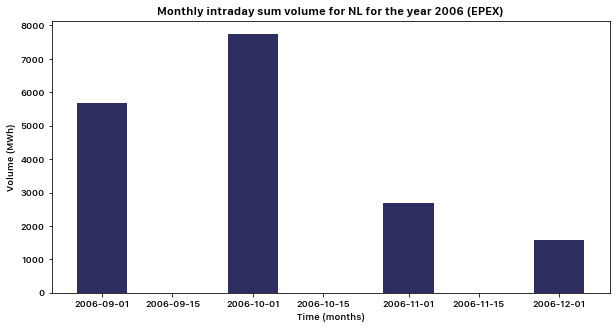

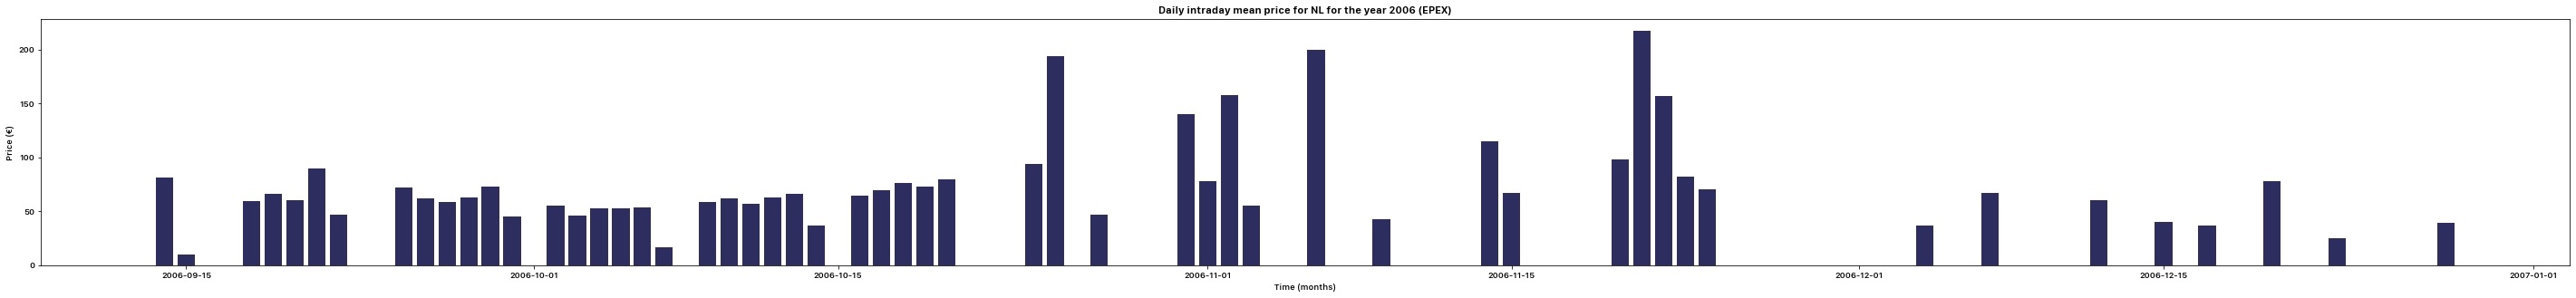


...

Year: 2007

Price: 132324 Euro
Volume: 27274 MWh



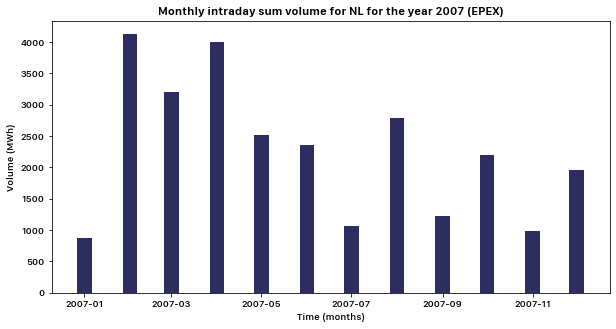

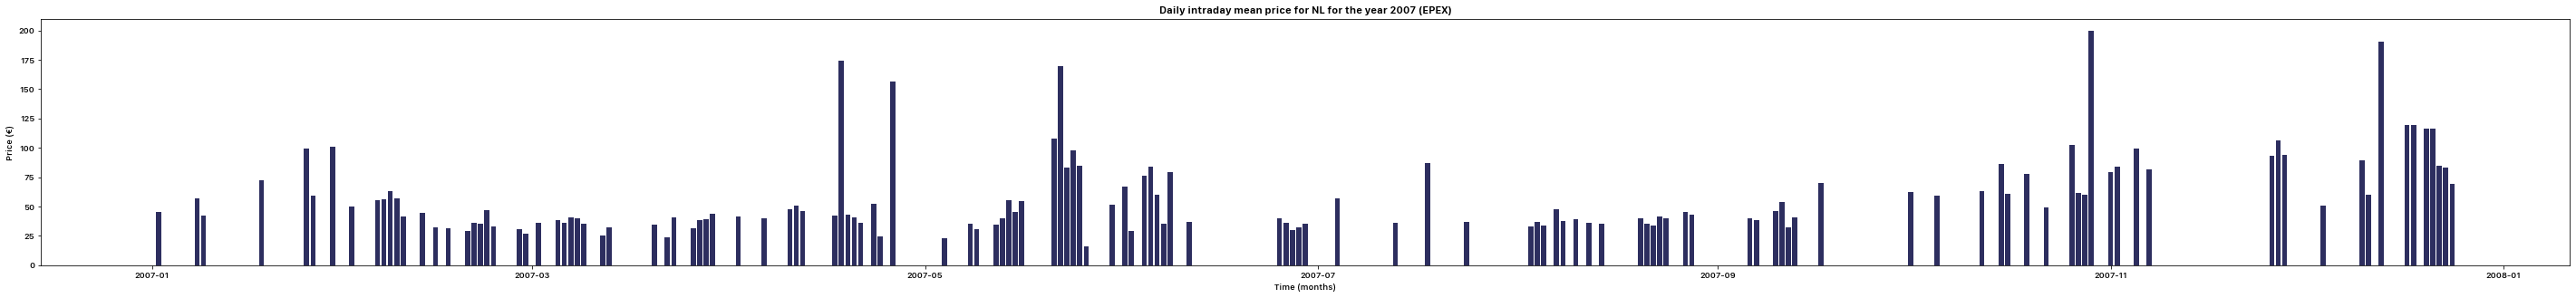


...

Year: 2008

Price: 291260 Euro
Volume: 37018 MWh



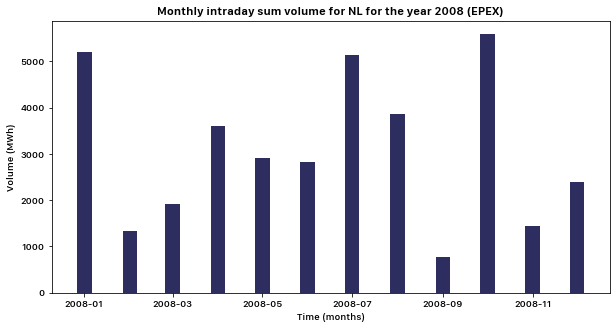

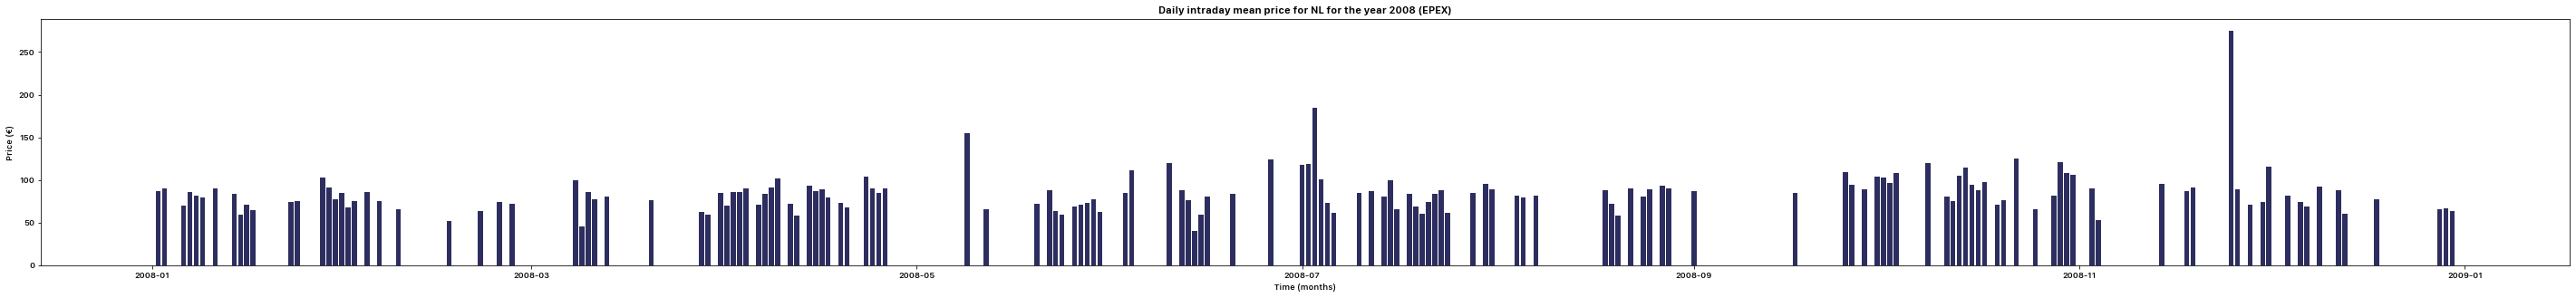


...

Year: 2009

Price: 238426 Euro
Volume: 88690 MWh



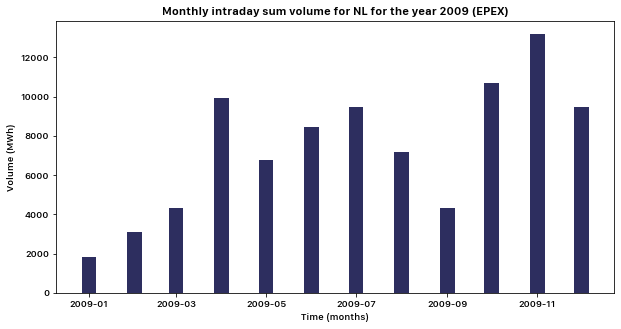

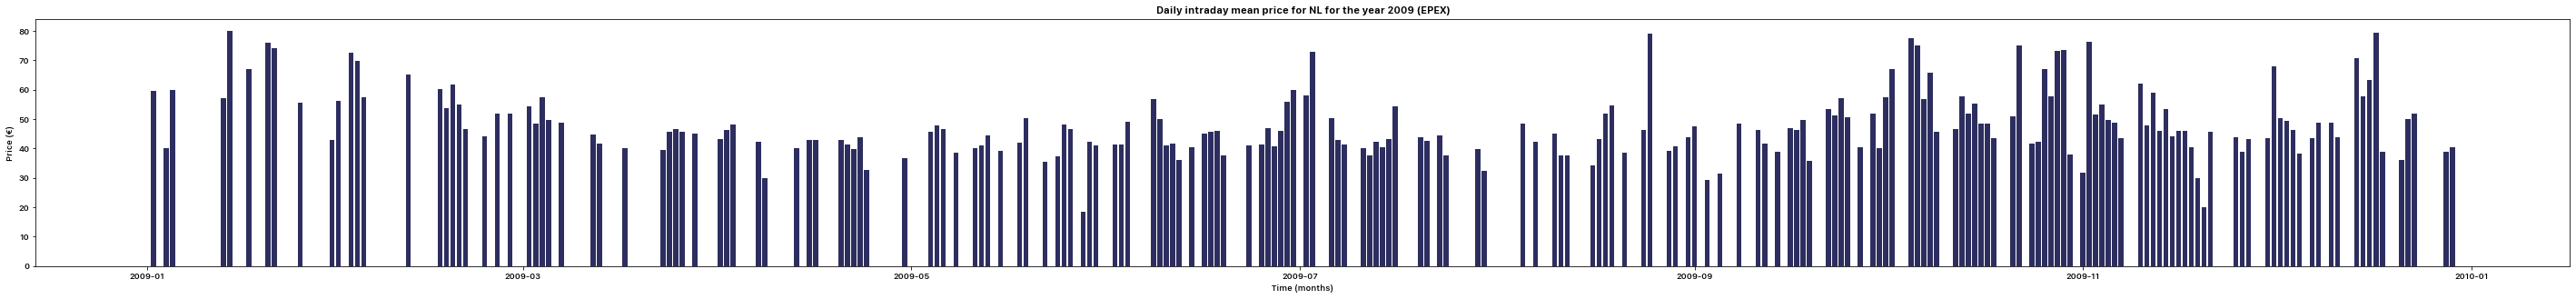


...

Year: 2010

Price: 126350 Euro
Volume: 55714 MWh



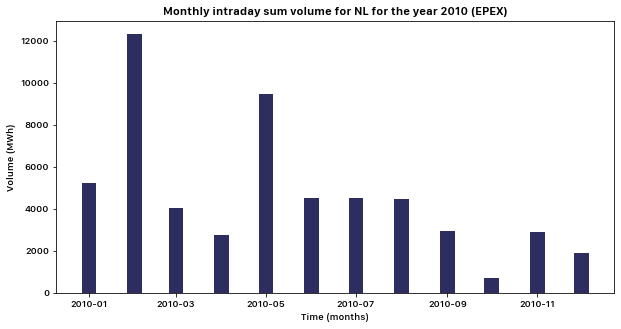

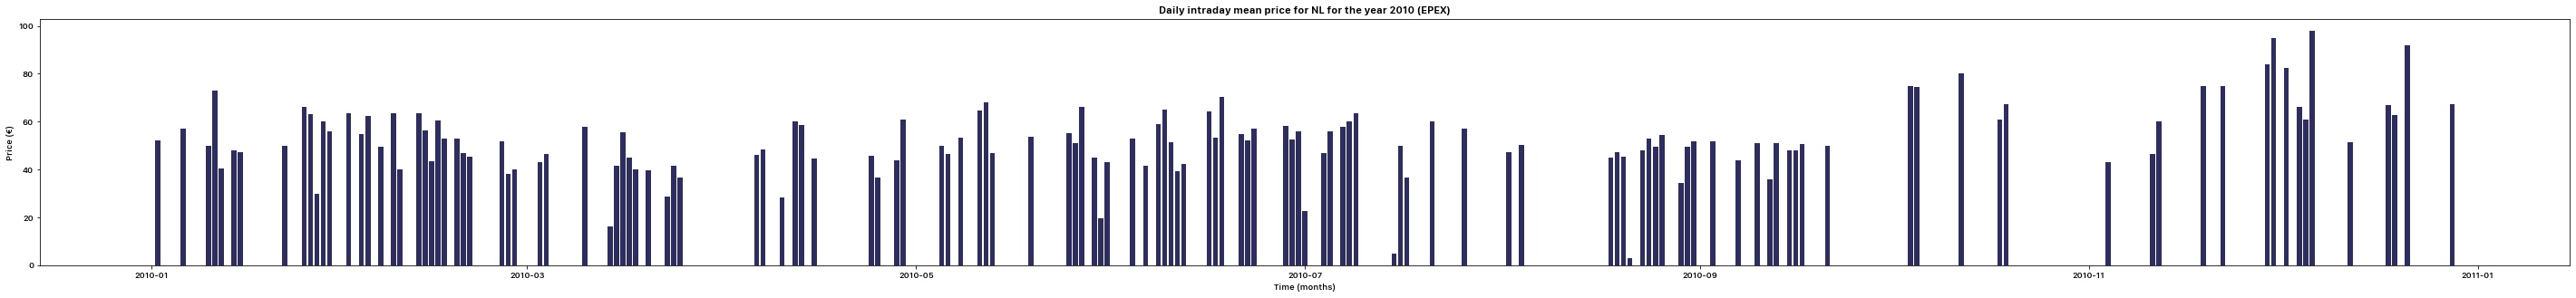


...

Year: 2011

Price: 365706 Euro
Volume: 555878 MWh



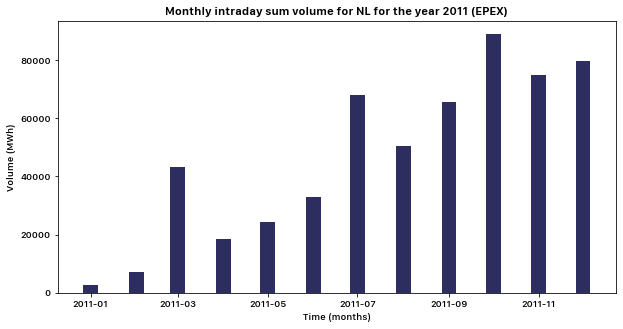

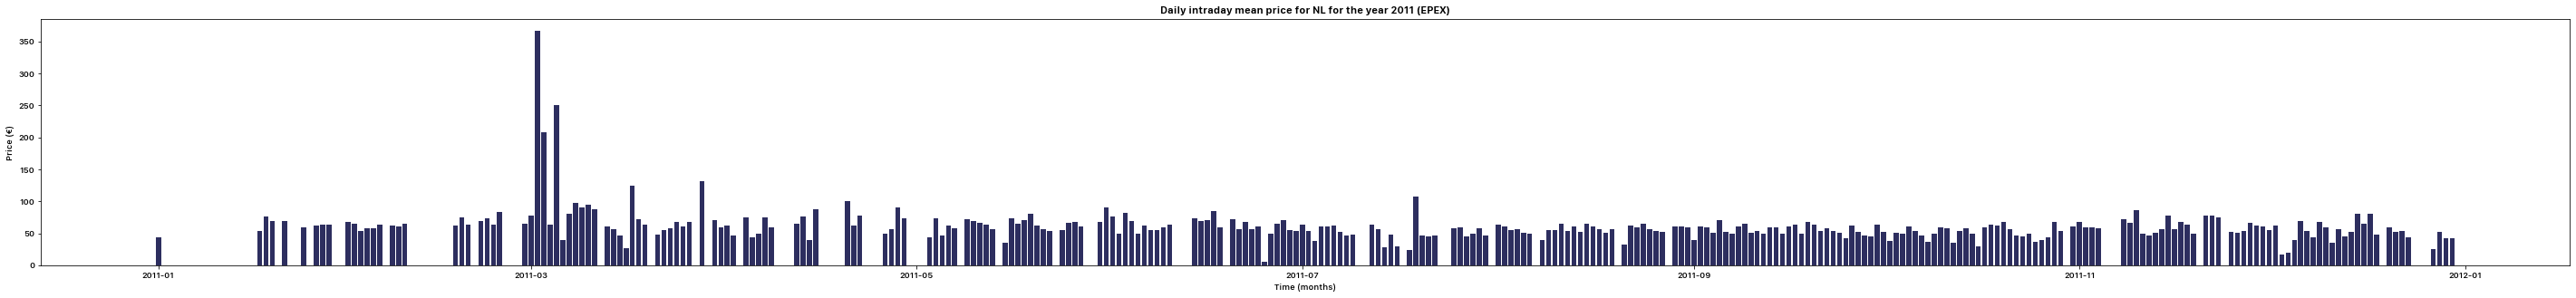


...

Year: 2012

Price: 902296 Euro
Volume: 904976 MWh



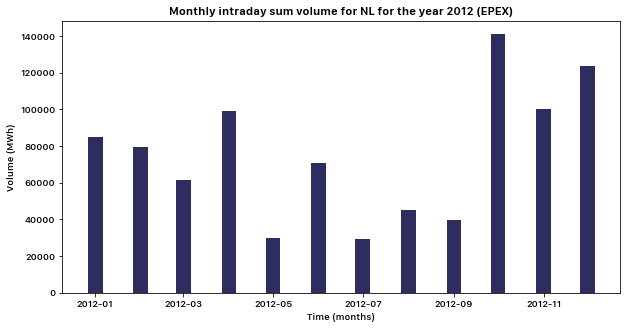

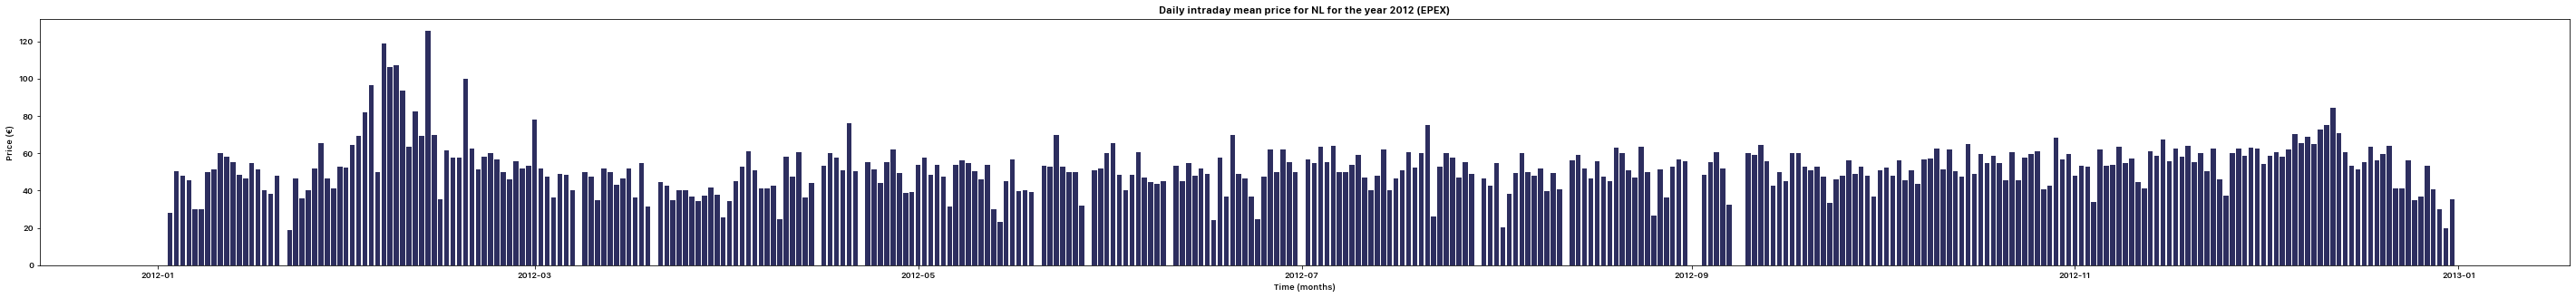


...

Year: 2013

Price: 2274638 Euro
Volume: 1445876 MWh



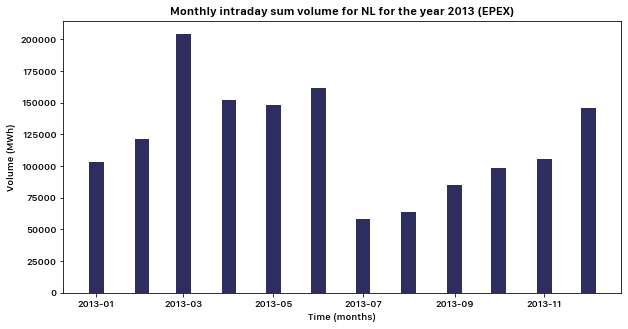

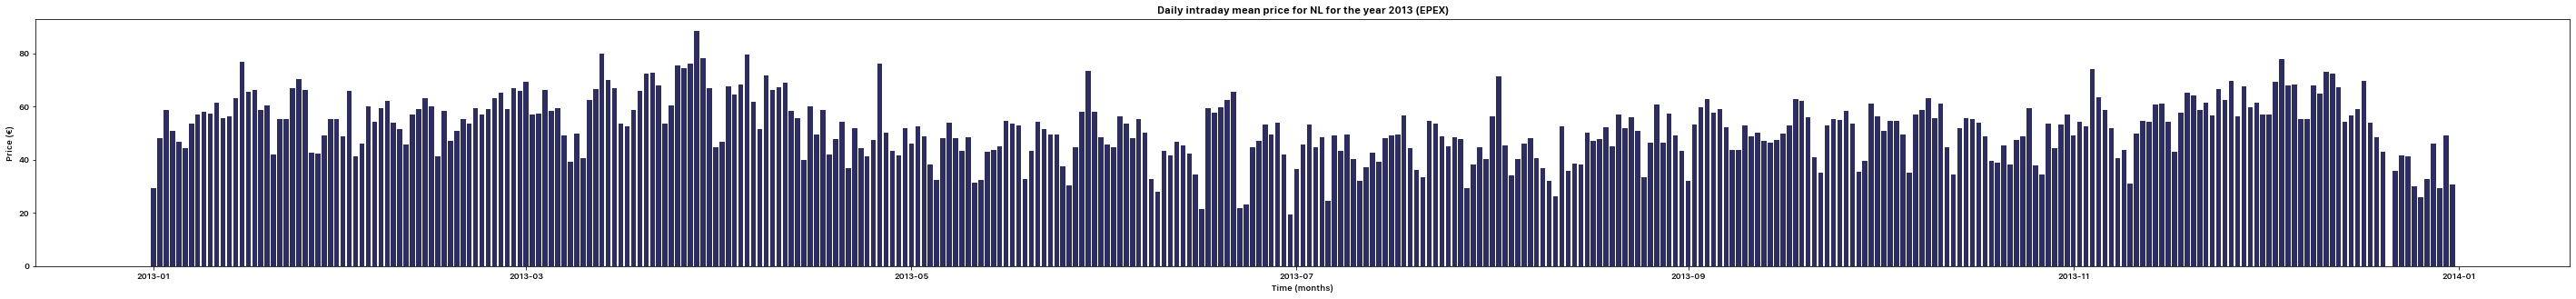


...

Year: 2014

Price: 2885352 Euro
Volume: 2037272 MWh



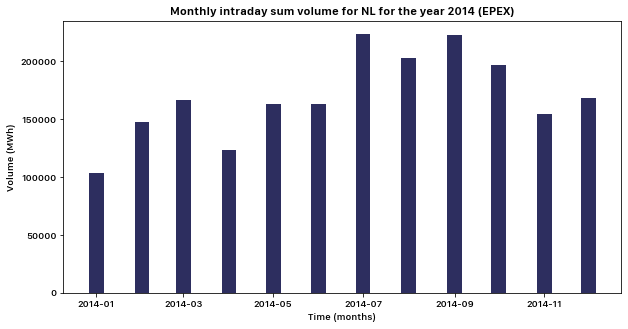

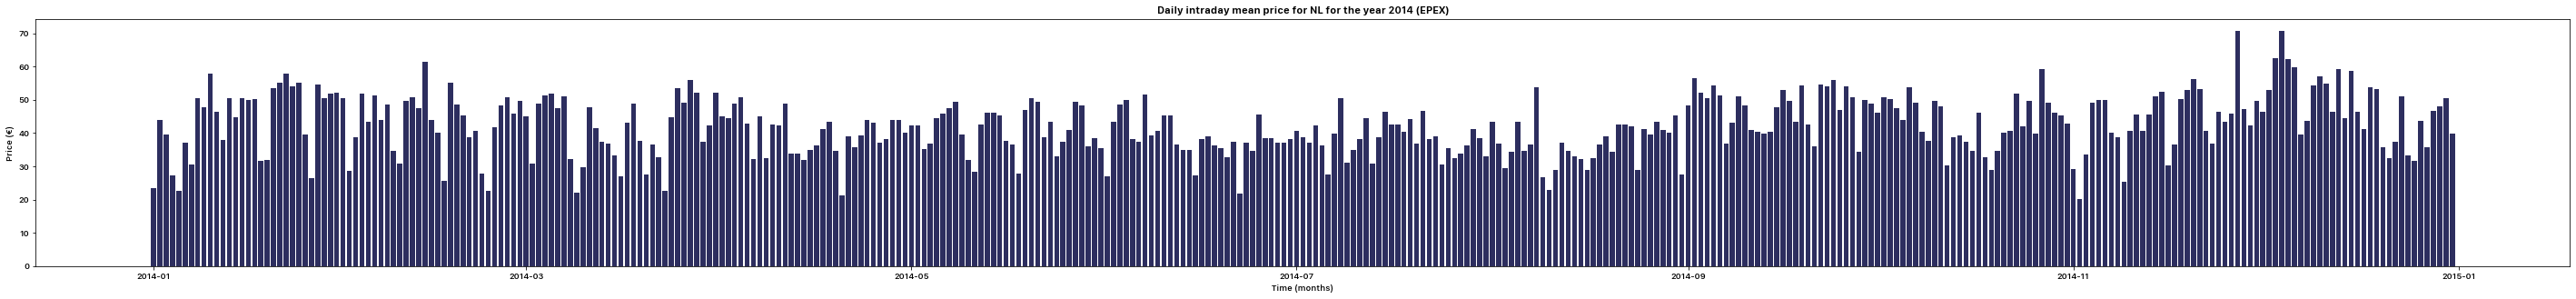


...

Year: 2015

Price: 3570300 Euro
Volume: 1895054 MWh



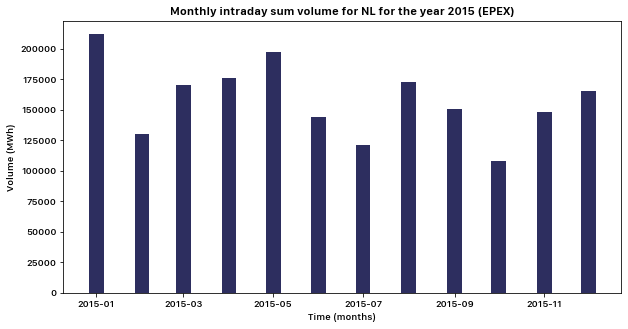

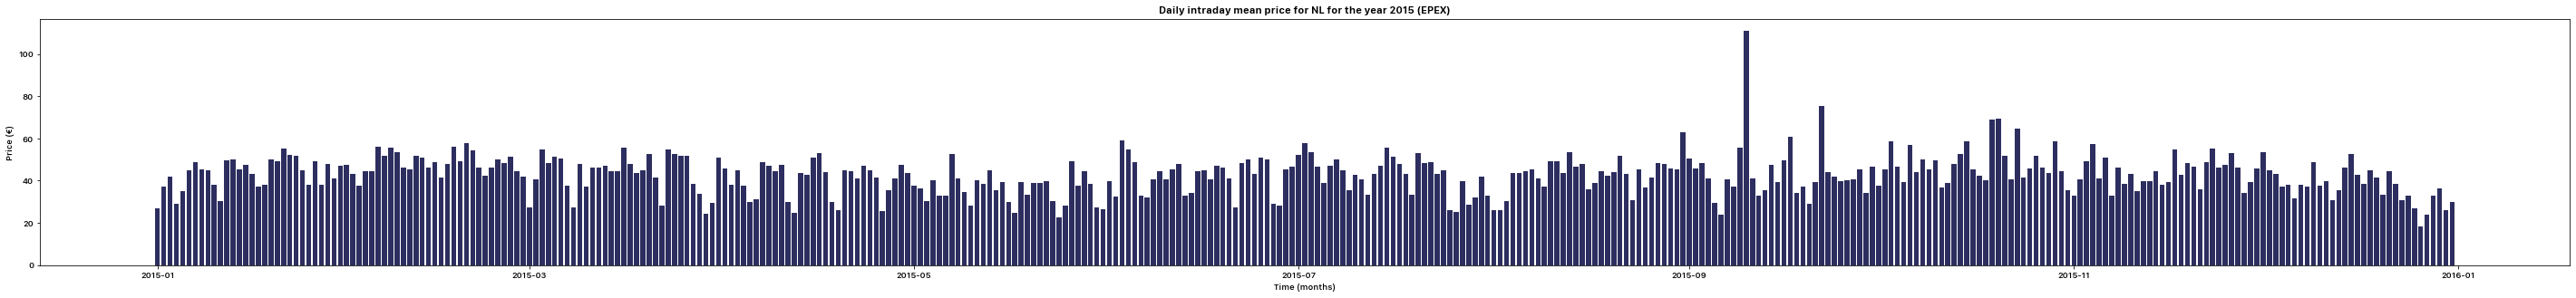


...

Year: 2016

Price: 4341262 Euro
Volume: 2896962 MWh



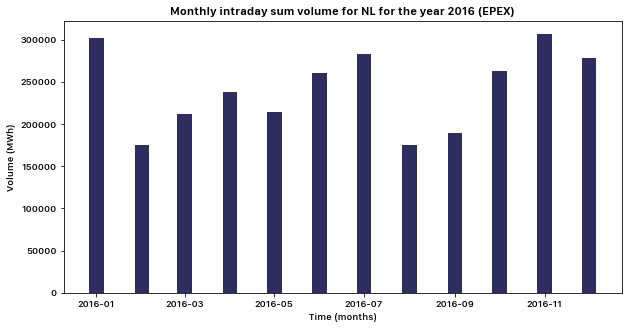

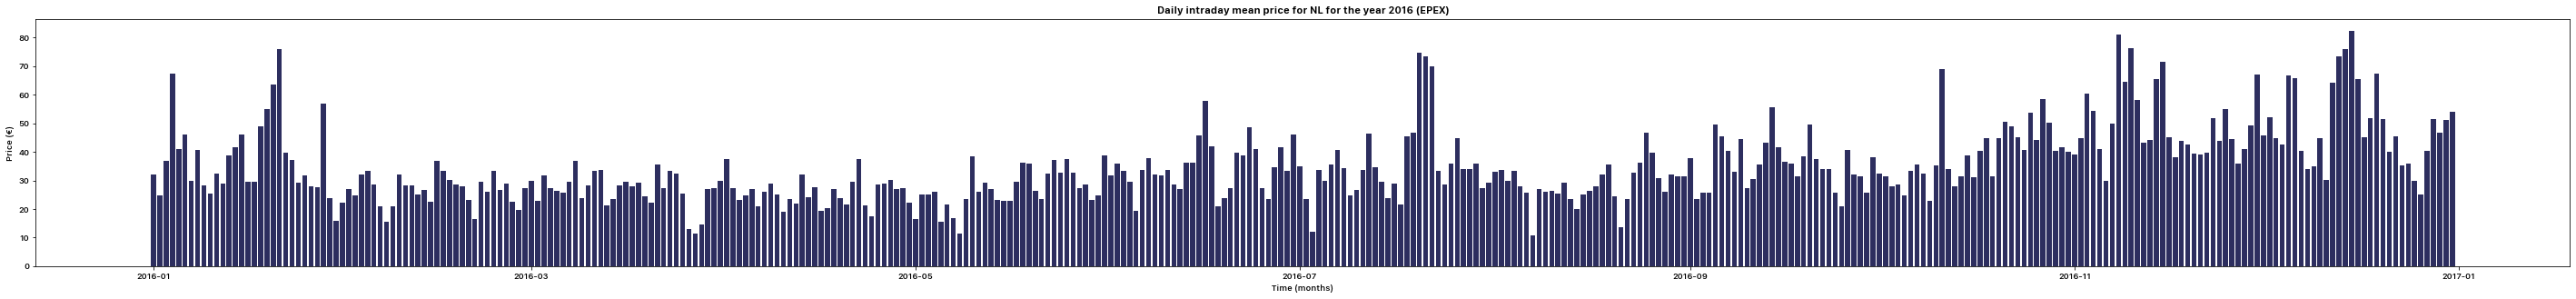


...

Year: 2017

Price: 13851618 Euro
Volume: 4728178 MWh



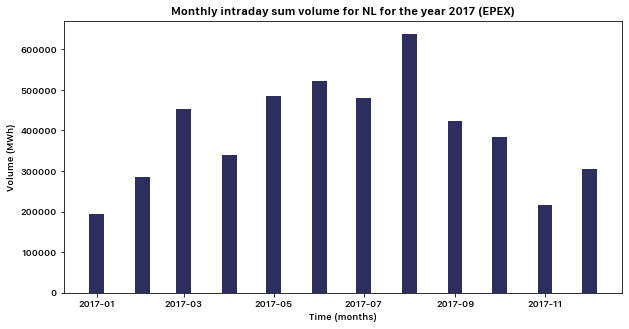

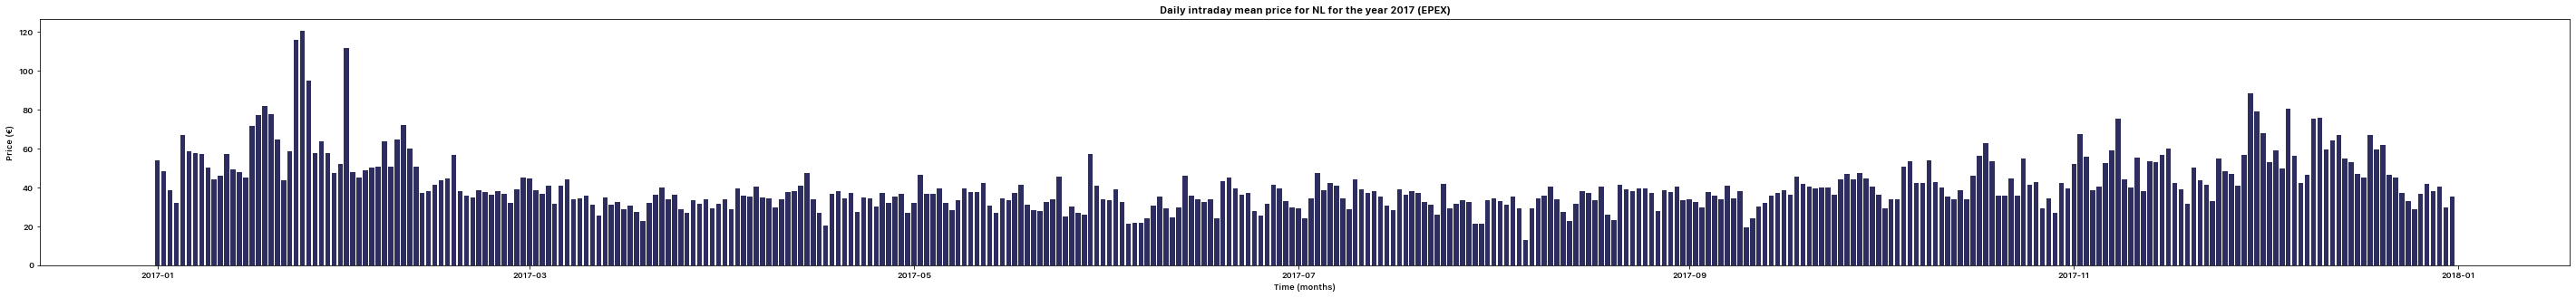


...

Year: 2018

Price: 45652896 Euro
Volume: 6716162 MWh



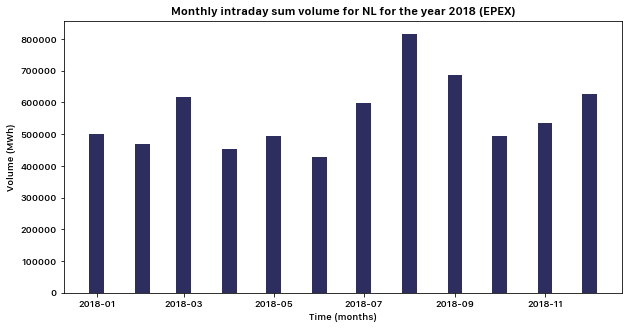

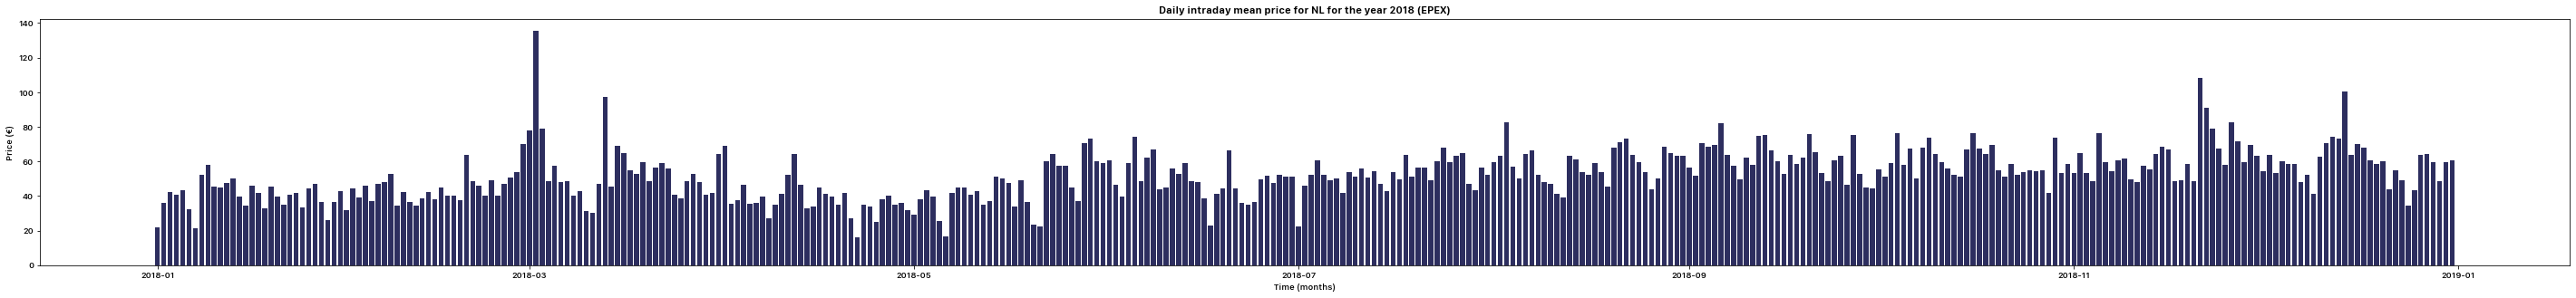


...

Year: 2019

Price: 44130106 Euro
Volume: 5131188 MWh



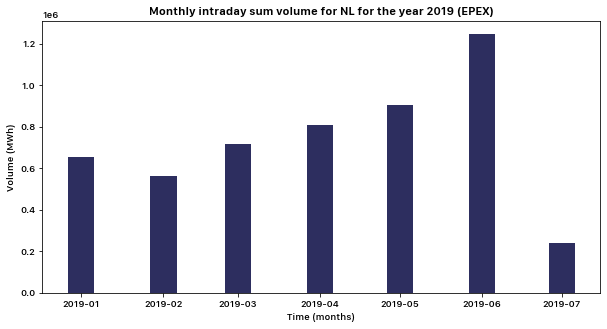

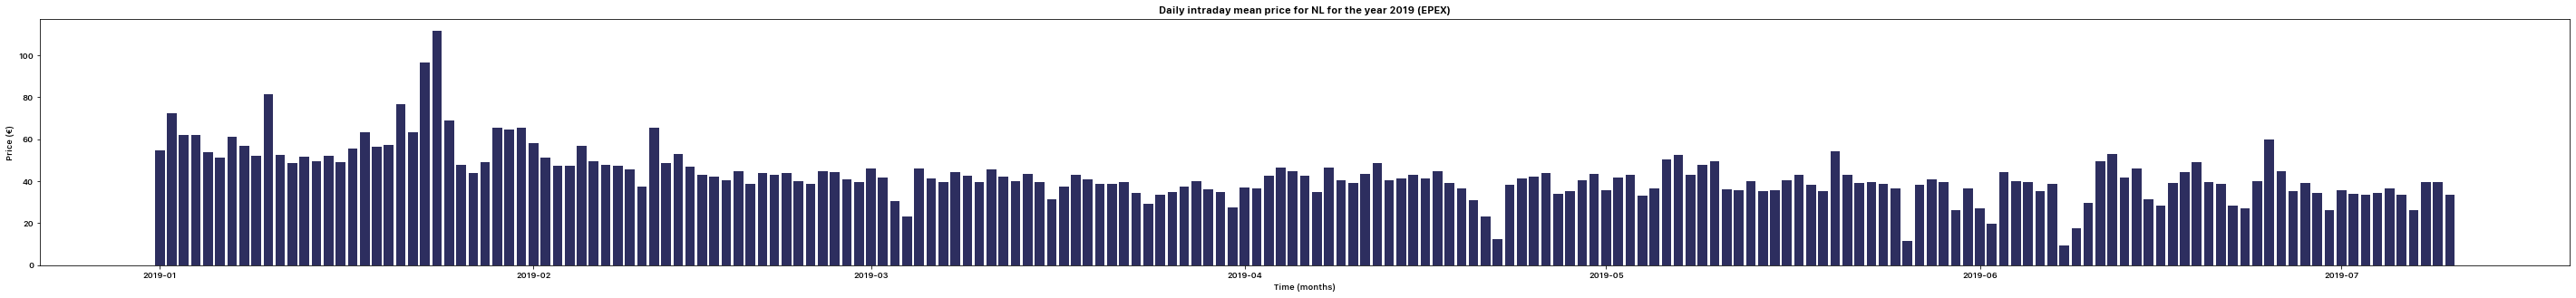


...

Period: 2006–2019
Price: 118836458 Euro
Volume: 26537950 MWh

...



In [2]:
years = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
country = 'NL'

dfo = pd.DataFrame()
dfo2 = pd.DataFrame()
price = []
volume = []
breaks = []

for y in years:
    i = years.index(y)

    df = pd.read_pickle(f"./{y}_Intraday.pkl")

    df['Price'] = df['Price'].astype('int64')
    df['Volume'] = df['Volume'].astype('int64')

    volume_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Volume'].sum()
    volume_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Volume'].sum()

    price_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Price'].sum()
    price_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Price'].sum()

    df_group = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    df_group['Date'] = df_group.index
    df_group['Date'] = pd.to_datetime(df_group['Date'], format='(%Y, %m)')

    df_group2 = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day)]).mean()
    df_group2['Date'] = df_group2.index
    df_group2['Date'] = pd.to_datetime(df_group2['Date'], format='(%Y, %m, %d)')

    dfo = dfo.append(df_group, ignore_index = False)
    dfo2 = dfo2.append(df, ignore_index = False)
    breaks.append(len(dfo))

    price.append(df['Price'].sum())
    volume.append(df['Volume'].sum())
    
    print('')
    print(colored('...','white'))
    print('')
    print(colored(f'Year: {y}', 'blue'))
    print('')
    print(colored(f'Price: {int(round(price[i]))} Euro', 'blue'))
    print(colored(f'Volume: {int(round(volume[i]))} MWh', 'blue'))
    print('')

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(df_group['Date'], df_group['Volume'], width=10)
    ax.set_title(f'Monthly intraday sum volume for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Volume (MWh)')
    plt.show()

    fig, ax = plt.subplots(figsize=(50, 5))
    ax.bar(df_group2['Date'], df_group2['Price'])
    ax.set_title(f'Daily intraday mean price for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Price (€)')
    plt.show()

print('')
print(colored('...','white'))
print('')
print(colored(f'Period: {years[0]}–{years[-1]}', 'blue'))
print(colored(f'Price: {int(round(sum(price)))} Euro', 'blue'))
print(colored(f'Volume: {int(round(sum(volume)))} MWh', 'blue'))
print('')
print(colored('...','white'))
print('')

Text(0, 0.5, 'Volume (MWh)')

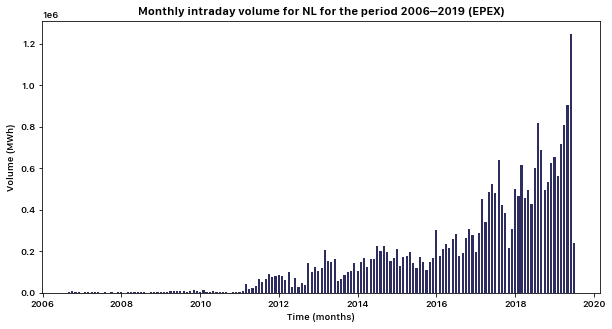

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(dfo['Date'], dfo['Volume'], width=20)
ax.set_title(f'Monthly intraday volume for {country} for the period {years[0]}–{years[-1]} (EPEX)')
ax.set_xlabel(r'Time (months)')
ax.set_ylabel(r'Volume (MWh)')